In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from thirdparty.fem_2d_rec import fem_poisson_solver,mesh_fem_2d_rec,get_matrices_2d
from common.util import create_boundary_mask, create_interior_mask, Dirichlet_bc_tensor, Dirichlet_bc_array, he_weights_init
from models.autoencoder import Autoencoder
from loss.loss import unsupervised_loss, h_loss

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
f_values = np.arange(-5000, 5000, 2)
np.savetxt('./f_constant.txt', f_values, fmt='%f')
print("Create f_constant.txt.")

In [2]:
f_values = np.loadtxt('./f_constant.txt')
print(f"Loaded {len(f_values)} f function.")

Loaded 5000 f function.


In [3]:
# input_shape = (256, 256)
# f_matrices = np.array([np.full(input_shape, f_value) for f_value in f_values])
# print(f"{len(f_matrices)} f matrices")

In [4]:
input_shape = (256, 256)
f_matrices = []
for f_value in f_values:
    f_matrix = np.full(input_shape, f_value)
    f_matrix_with_boundary = Dirichlet_bc_array(f_matrix)
    f_matrices.append(f_matrix_with_boundary)
    
print(f_matrices)

[array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0., -5000., -5000., ..., -5000., -5000.,     0.],
       [    0., -5000., -5000., ..., -5000., -5000.,     0.],
       ...,
       [    0., -5000., -5000., ..., -5000., -5000.,     0.],
       [    0., -5000., -5000., ..., -5000., -5000.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]]), array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0., -4998., -4998., ..., -4998., -4998.,     0.],
       [    0., -4998., -4998., ..., -4998., -4998.,     0.],
       ...,
       [    0., -4998., -4998., ..., -4998., -4998.,     0.],
       [    0., -4998., -4998., ..., -4998., -4998.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]]), array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0., -4996., -4996., ..., -4996., -4996.,     0.],
       [    0., -4996., -4996., ..., -4996., -4996.,     0.],
       ...,
       [    0., -4996., -4996

In [5]:
class PoissonDataset(Dataset):
    def __init__(self, f_matrices):
        self.f_matrices = f_matrices

    def __len__(self):
        return len(self.f_matrices)

    def __getitem__(self, idx):
        f_matrix = self.f_matrices[idx]
        f_tensor = torch.tensor(f_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return f_tensor

In [6]:
dataset = PoissonDataset(f_matrices)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [7]:
a = 0
b = 1
k = 1
M = 255
h = 1 / M

In [8]:
def unsupervised_loss(u_pred, f, h, interior_mask, boundary_mask):
    laplacian_filter = torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(u_pred.device) # (1, 1, H, W) 형태로 변환 / 마이너스 라플라시안 필터
    laplacian_u = torch.nn.functional.conv2d(u_pred, laplacian_filter, padding=1)

    interior_loss = torch.sum(((f * h**2 - laplacian_u) ** 2) * interior_mask)
    # boundary_loss = torch.sum((u_pred * boundary_mask) ** 2)

    return interior_loss

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, rep_dim=128):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, rep_dim),
            nn.ReLU()
        )

        # Latent space
        self.fc = nn.Linear(rep_dim, rep_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(rep_dim, 128 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        latent = self.fc(encoded)
        u_pred = self.decoder(latent)
        return u_pred, latent

  1%|          | 1/100 [00:05<09:52,  5.99s/it]

Loss: 119773.93229140625


  2%|▏         | 2/100 [00:11<09:42,  5.95s/it]

Loss: 2138.712522363281


  3%|▎         | 3/100 [00:17<09:32,  5.90s/it]

Loss: 1560.7745009765624


  4%|▍         | 4/100 [00:23<09:21,  5.85s/it]

Loss: 1372.5797624023437


  5%|▌         | 5/100 [00:29<09:14,  5.84s/it]

Loss: 1276.5831630371094


  6%|▌         | 6/100 [00:35<09:10,  5.86s/it]

Loss: 1374.680261376953


  7%|▋         | 7/100 [00:41<09:04,  5.86s/it]

Loss: 1536.3444266601562


  8%|▊         | 8/100 [00:46<08:54,  5.81s/it]

Loss: 1295.8404953125


  9%|▉         | 9/100 [00:52<08:46,  5.79s/it]

Loss: 1366.57772265625


 10%|█         | 10/100 [00:58<08:37,  5.75s/it]

Loss: 1418.1762125976563


 11%|█         | 11/100 [01:04<08:34,  5.79s/it]

Loss: 1362.0481100097657


 12%|█▏        | 12/100 [01:09<08:31,  5.81s/it]

Loss: 1303.7506939941406


 13%|█▎        | 13/100 [01:15<08:27,  5.84s/it]

Loss: 1269.6877065429687


 14%|█▍        | 14/100 [01:21<08:23,  5.86s/it]

Loss: 1211.461272607422


 15%|█▌        | 15/100 [01:27<08:19,  5.88s/it]

Loss: 1262.18141953125


 16%|█▌        | 16/100 [01:33<08:14,  5.88s/it]

Loss: 1120.2682724121094


 17%|█▋        | 17/100 [01:39<08:05,  5.85s/it]

Loss: 1169.462011328125


 18%|█▊        | 18/100 [01:45<08:00,  5.86s/it]

Loss: 1129.1294403808595


 19%|█▉        | 19/100 [01:51<07:54,  5.86s/it]

Loss: 1155.9679247802735


 20%|██        | 20/100 [01:57<07:51,  5.89s/it]

Loss: 1100.6690629394532


 21%|██        | 21/100 [02:03<07:47,  5.92s/it]

Loss: 1094.4668715820312


 22%|██▏       | 22/100 [02:08<07:43,  5.94s/it]

Loss: 1089.377189038086


 23%|██▎       | 23/100 [02:15<07:38,  5.96s/it]

Loss: 1069.752522265625


 24%|██▍       | 24/100 [02:20<07:31,  5.94s/it]

Loss: 1071.201598095703


 25%|██▌       | 25/100 [02:26<07:24,  5.92s/it]

Loss: 1060.1099673828126


 26%|██▌       | 26/100 [02:32<07:16,  5.90s/it]

Loss: 1045.6422713867187


 27%|██▋       | 27/100 [02:38<07:10,  5.90s/it]

Loss: 1049.6390233886718


 28%|██▊       | 28/100 [02:44<07:02,  5.87s/it]

Loss: 1036.63648671875


 29%|██▉       | 29/100 [02:50<07:00,  5.93s/it]

Loss: 1029.8999067871093


 30%|███       | 30/100 [02:56<06:56,  5.95s/it]

Loss: 1028.0876114746093


 31%|███       | 31/100 [03:02<06:53,  6.00s/it]

Loss: 1015.4574526855469


 32%|███▏      | 32/100 [03:08<06:47,  5.99s/it]

Loss: 1013.2066518798828


 33%|███▎      | 33/100 [03:14<06:40,  5.97s/it]

Loss: 1009.6556946289063


 34%|███▍      | 34/100 [03:20<06:34,  5.97s/it]

Loss: 999.5564388183594


 35%|███▌      | 35/100 [03:26<06:27,  5.96s/it]

Loss: 996.4595780395508


 36%|███▌      | 36/100 [03:32<06:21,  5.96s/it]

Loss: 986.8164875732422


 37%|███▋      | 37/100 [03:38<06:15,  5.96s/it]

Loss: 982.7691562744141


 38%|███▊      | 38/100 [03:44<06:09,  5.96s/it]

Loss: 969.7925965332031


 39%|███▉      | 39/100 [03:50<06:03,  5.95s/it]

Loss: 962.4954536865234


 40%|████      | 40/100 [03:56<05:56,  5.94s/it]

Loss: 958.3838249267578


 41%|████      | 41/100 [04:02<05:50,  5.95s/it]

Loss: 952.7169872802734


 42%|████▏     | 42/100 [04:07<05:45,  5.96s/it]

Loss: 950.3776263183594


 43%|████▎     | 43/100 [04:13<05:38,  5.95s/it]

Loss: 946.2869536621093


 44%|████▍     | 44/100 [04:19<05:31,  5.92s/it]

Loss: 941.1629369628906


 45%|████▌     | 45/100 [04:25<05:27,  5.96s/it]

Loss: 933.8930011230469


 46%|████▌     | 46/100 [04:31<05:24,  6.02s/it]

Loss: 928.0955524414062


 47%|████▋     | 47/100 [04:38<05:21,  6.06s/it]

Loss: 928.8551217529297


 48%|████▊     | 48/100 [04:44<05:17,  6.10s/it]

Loss: 925.46517265625


 49%|████▉     | 49/100 [04:50<05:12,  6.13s/it]

Loss: 917.1736960449218


 50%|█████     | 50/100 [04:56<05:08,  6.17s/it]

Loss: 923.9700673339844


 51%|█████     | 51/100 [05:03<05:04,  6.21s/it]

Loss: 921.6815708007813


 52%|█████▏    | 52/100 [05:09<04:57,  6.19s/it]

Loss: 907.1272403076172


 53%|█████▎    | 53/100 [05:15<04:50,  6.18s/it]

Loss: 913.4872513671875


 54%|█████▍    | 54/100 [05:21<04:41,  6.11s/it]

Loss: 906.4862674804688


 55%|█████▌    | 55/100 [05:27<04:32,  6.07s/it]

Loss: 927.9694227050782


 56%|█████▌    | 56/100 [05:33<04:28,  6.11s/it]

Loss: 897.7313145996094


 57%|█████▋    | 57/100 [05:39<04:23,  6.12s/it]

Loss: 898.3742471191406


 58%|█████▊    | 58/100 [05:45<04:16,  6.10s/it]

Loss: 892.9565109863281


 59%|█████▉    | 59/100 [05:51<04:08,  6.06s/it]

Loss: 897.8096314941406


 60%|██████    | 60/100 [05:57<04:03,  6.09s/it]

Loss: 890.2785085449219


 61%|██████    | 61/100 [06:03<03:56,  6.06s/it]

Loss: 888.1839850097656


 62%|██████▏   | 62/100 [06:09<03:49,  6.04s/it]

Loss: 886.8631499023437


 63%|██████▎   | 63/100 [06:15<03:42,  6.02s/it]

Loss: 882.0713041015625


 64%|██████▍   | 64/100 [06:21<03:37,  6.05s/it]

Loss: 881.9882891357422


 65%|██████▌   | 65/100 [06:27<03:32,  6.06s/it]

Loss: 881.7093153320312


 66%|██████▌   | 66/100 [06:33<03:25,  6.04s/it]

Loss: 876.770457446289


 67%|██████▋   | 67/100 [06:39<03:18,  6.03s/it]

Loss: 876.711064086914


 68%|██████▊   | 68/100 [06:46<03:14,  6.08s/it]

Loss: 875.8838399902344


 69%|██████▉   | 69/100 [06:52<03:09,  6.12s/it]

Loss: 872.9308303222656


 70%|███████   | 70/100 [06:58<03:03,  6.13s/it]

Loss: 874.0839026611328


 71%|███████   | 71/100 [07:04<02:58,  6.16s/it]

Loss: 869.8567699462891


 72%|███████▏  | 72/100 [07:11<02:53,  6.21s/it]

Loss: 867.0075287597656


 73%|███████▎  | 73/100 [07:17<02:46,  6.18s/it]

Loss: 868.3268584228516


 74%|███████▍  | 74/100 [07:23<02:39,  6.12s/it]

Loss: 865.5632736572265


 75%|███████▌  | 75/100 [07:29<02:32,  6.08s/it]

Loss: 865.0548791381835


 76%|███████▌  | 76/100 [07:35<02:25,  6.08s/it]

Loss: 862.5630755615234


 77%|███████▋  | 77/100 [07:41<02:18,  6.04s/it]

Loss: 863.3857793212891


 78%|███████▊  | 78/100 [07:47<02:12,  6.02s/it]

Loss: 862.2569032470703


 79%|███████▉  | 79/100 [07:53<02:05,  5.96s/it]

Loss: 857.6865527099609


 80%|████████  | 80/100 [07:58<01:59,  5.95s/it]

Loss: 860.3793129882813


 81%|████████  | 81/100 [08:04<01:52,  5.93s/it]

Loss: 852.9685018554687


 82%|████████▏ | 82/100 [08:10<01:46,  5.94s/it]

Loss: 857.0570840820312


 83%|████████▎ | 83/100 [08:16<01:41,  5.96s/it]

Loss: 857.1932689208984


 84%|████████▍ | 84/100 [08:23<01:36,  6.05s/it]

Loss: 853.4291639648437


 85%|████████▌ | 85/100 [08:29<01:31,  6.12s/it]

Loss: 852.9917160644532


 86%|████████▌ | 86/100 [08:35<01:25,  6.10s/it]

Loss: 849.8131071777344


 87%|████████▋ | 87/100 [08:41<01:19,  6.09s/it]

Loss: 851.7881702636719


 88%|████████▊ | 88/100 [08:47<01:12,  6.06s/it]

Loss: 856.908851977539


 89%|████████▉ | 89/100 [08:53<01:06,  6.03s/it]

Loss: 850.7902447021485


 90%|█████████ | 90/100 [08:59<01:00,  6.05s/it]

Loss: 842.4238186035157


 91%|█████████ | 91/100 [09:05<00:54,  6.02s/it]

Loss: 846.2363369628906


 92%|█████████▏| 92/100 [09:11<00:47,  5.97s/it]

Loss: 849.8674803710937


 93%|█████████▎| 93/100 [09:17<00:41,  5.97s/it]

Loss: 844.0799337402344


 94%|█████████▍| 94/100 [09:23<00:35,  5.93s/it]

Loss: 845.9930873046875


 95%|█████████▌| 95/100 [09:29<00:29,  5.94s/it]

Loss: 841.4381200439453


 96%|█████████▌| 96/100 [09:35<00:24,  6.05s/it]

Loss: 843.4655018066406


 97%|█████████▋| 97/100 [09:41<00:18,  6.14s/it]

Loss: 842.2952820068359


 98%|█████████▊| 98/100 [09:47<00:12,  6.15s/it]

Loss: 849.8398973632812


 99%|█████████▉| 99/100 [09:53<00:06,  6.12s/it]

Loss: 835.9391663818359


100%|██████████| 100/100 [09:59<00:00,  6.00s/it]

Loss: 836.4237258300781


Last Loss: 836.4237 Last model saved to last_autoencoder_model.pth
Best Loss: 835.9392 Best model saved to best_autoencoder_model.pth


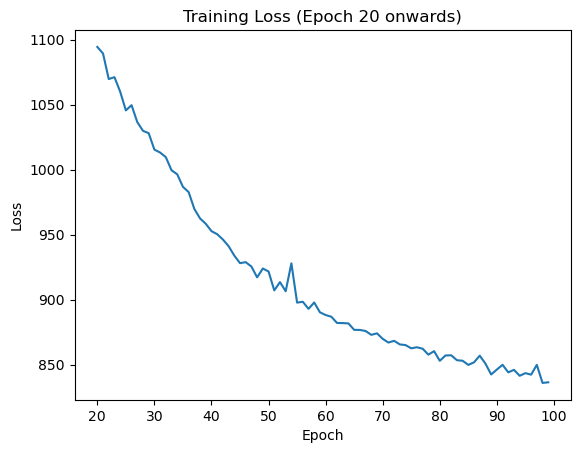

In [14]:
model = Autoencoder()
model.apply(he_weights_init)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)

boundary_mask = create_boundary_mask((256, 256)).to(device)
interior_mask = create_interior_mask((256, 256)).to(device)

num_epochs = 100
best_loss = float('inf')
train_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for data in train_loader:
        inputs = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        u_pred, _ = model(inputs)
        u_pred = Dirichlet_bc_tensor(u_pred, g=0)
        loss = unsupervised_loss(u_pred, inputs, h, interior_mask, boundary_mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Loss: {train_loss}')
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = model.state_dict()

torch.save(model.state_dict(), 'last_autoencoder_model.pth')
torch.save(best_model_wts, 'best_autoencoder_model.pth')

print(f'Last Loss: {train_loss:.4f} Last model saved to last_autoencoder_model.pth')
print(f'Best Loss: {best_loss:.4f} Best model saved to best_autoencoder_model.pth')

plt.plot(range(20, num_epochs), train_losses[20:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Epoch 20 onwards)')
plt.show()

In [15]:
model.load_state_dict(torch.load('best_autoencoder_model.pth'))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=131072, out_features=128, bias=True)
    (11): ReLU()
  )
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=131072, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 32, 32))
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2)

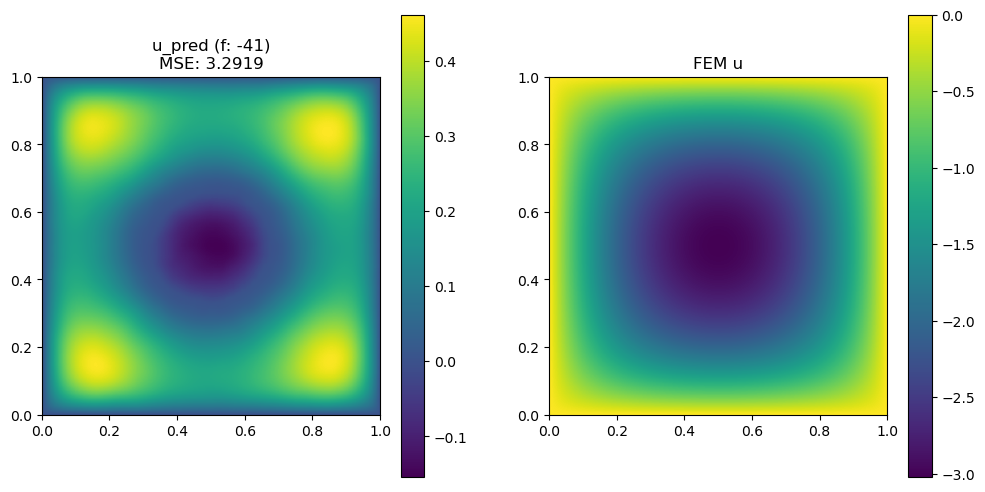

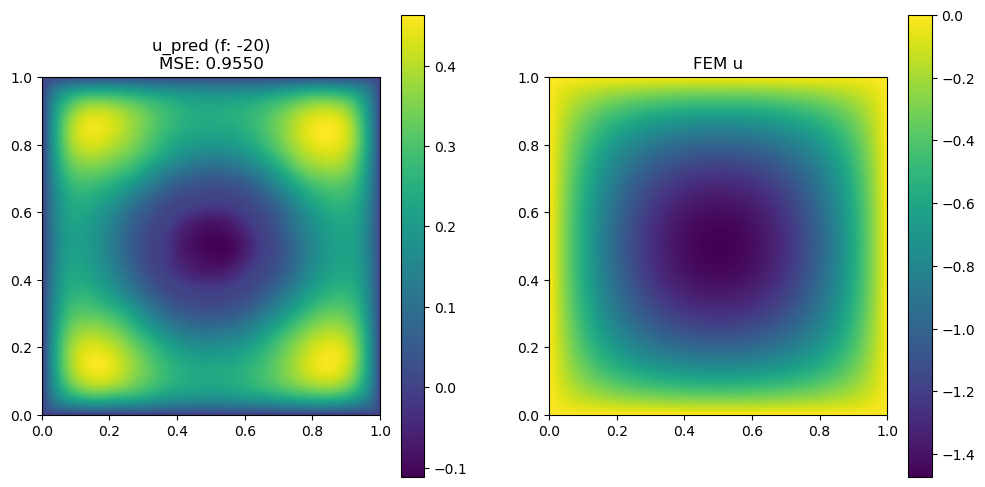

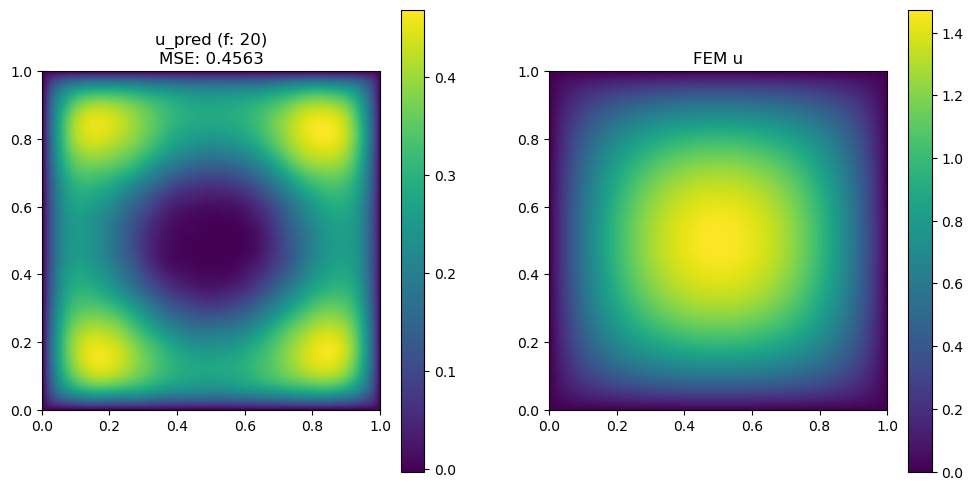

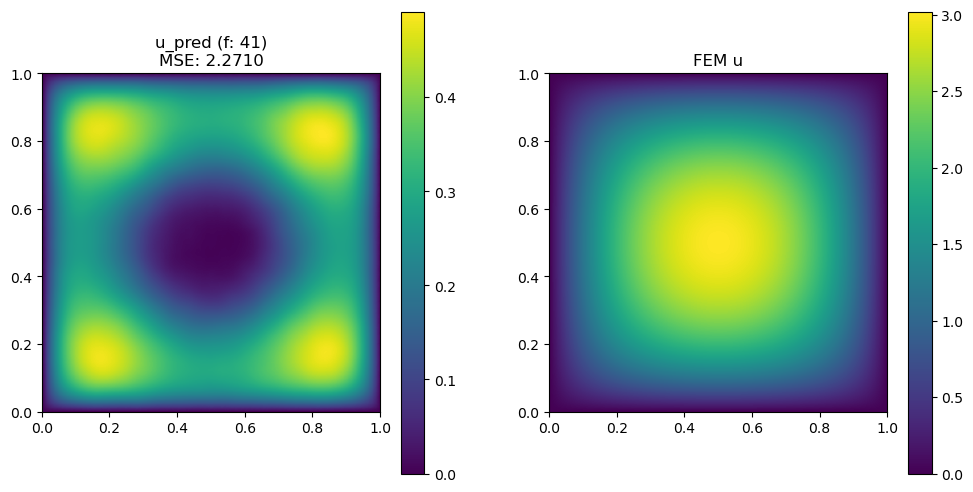

In [17]:
test_f_values = [-41, -20, 20, 41]
c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)

for test_f_value in test_f_values:
    new_f = np.full((256, 256), test_f_value)
    f_tensor = torch.tensor(new_f).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        predicted_u, _ = model(f_tensor)

    predicted_u = Dirichlet_bc_array(predicted_u.squeeze().cpu().numpy())

    f = lambda x: np.full(x.shape[0], test_f_value)
    u_D = lambda x: x[:,0] * 0

    fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
    fem_u_reshaped = fem_u.reshape((256, 256))
    
    mse = np.mean((predicted_u - fem_u_reshaped) ** 2)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"u_pred (f: {test_f_value})\nMSE: {mse:.4f}")
    plt.imshow(predicted_u, cmap='viridis', extent=(0, 1, 0, 1))
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"FEM u")
    plt.imshow(fem_u_reshaped, cmap='viridis', extent=(0, 1, 0, 1))
    plt.colorbar()

    plt.show()

In [22]:
test_f_values = [-41, -20, 20, 41]
c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)

for test_f_value in test_f_values:
    new_f = np.full((256, 256), test_f_value)
    f_tensor = torch.tensor(new_f).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        predicted_u, _ = model(f_tensor)

    predicted_u = Dirichlet_bc_array(predicted_u.squeeze().cpu().numpy())

    f = lambda x: np.full(x.shape[0], test_f_value)
    u_D = lambda x: x[:,0] * 0

    fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
    fem_u_reshaped = fem_u.reshape((256, 256))
    
    mse = np.mean((predicted_u - fem_u_reshaped) ** 2)
    print(f'Mean Squared Error: {mse}\n')
    print(f'Predicted u: \n{predicted_u}\n')
    print(f'FEM u: \n{fem_u_reshaped}\n')

Mean Squared Error: 3.2918968611381776

Predicted u: 
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00406276 0.00571488 ... 0.00750332 0.00394353 0.        ]
 [0.         0.00527666 0.00950771 ... 0.01203762 0.00674717 0.        ]
 ...
 [0.         0.00599866 0.01268819 ... 0.00968701 0.00512361 0.        ]
 [0.         0.00626237 0.00757439 ... 0.005173   0.00325615 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

FEM u: 
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.00214422 -0.00393032 ... -0.00393032 -0.00214422
   0.        ]
 [ 0.         -0.00393032 -0.00740153 ... -0.00740153 -0.00393032
   0.        ]
 ...
 [ 0.         -0.00393032 -0.00740153 ... -0.00740153 -0.00393032
   0.        ]
 [ 0.         -0.00214422 -0.00393032 ... -0.00393032 -0.00214422
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]

Mean Squared Err